In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import yaml

from general_utils.files_utils import DirectoryUtils, FileUtils
abs_path = DirectoryUtils.getRosPkgPath('create_dataset')

In [2]:
objects_list = ["000_cereal_box_UO", "001_chips_can",
"002_master_chef_can", "003_cracker_box", "004_sugar_box",
"005_tomato_soup_can", "006_mustard_bottle", "007_tuna_fish_can", "008_pudding_box",
"009_gelatin_box", "010_potted_meat_can", "011_banana", "012_strawberry", "013_apple",
"014_lemon", "015_peach", "016_pear", "017_orange", "018_plum", "019_pitcher_base",
"021_bleach_cleanser", "024_bowl", "025_mug", "026_sponge", "027_skillet", "029_plate",
"030_fork", "031_spoon", "032_knife", "033_spatula", "035_power_drill", "036_wood_block",
"037_scissors", "038_padlock", "040_large_marker", "042_adjustable_wrench",
"043_phillips_screwdriver", "044_flat_screwdriver", "048_hammer", "050_medium_clamp",
"051_large_clamp", "052_extra_large_clamp", "053_mini_soccer_ball", "054_softball",
"055_baseball", "056_tennis_ball", "057_racquetball", "058_golf_ball", "059_chain",
"061_foam_brick", "062_dice", "063-a_marbles", "063-b_marbles", "065-a_cups",
"065-b_cups", "065-c_cups", "065-d_cups", "065-e_cups", "065-f_cups", "065-g_cups",
"065-h_cups", "065-i_cups", "065-j_cups", "070-a_colored_wood_blocks", "070-b_colored_wood_blocks",
"071_nine_hole_peg_test", "072-a_toy_airplane", "072-b_toy_airplane", "072-c_toy_airplane",
"072-d_toy_airplane", "072-e_toy_airplane", "073-a_lego_duplo", "073-b_lego_duplo",
"073-c_lego_duplo", "073-d_lego_duplo", "073-e_lego_duplo", "073-f_lego_duplo", 
"073-g_lego_duplo", "077_rubiks_cube"]

objects_list = ["000_cereal_box_UO", "001_chips_can", "002_master_chef_can",
                "006_mustard_bottle"]


objects_dictionary = {}
for i, object in enumerate(objects_list):
    objects_dictionary.update({object:i})

# for key, val in objects_dictionary.items():
#     print(key, "\t\t", val)
    
dataset_name = "YCB_virtual"
data_set_path = os.path.join(abs_path, dataset_name)
data_set_images_path = os.path.join(data_set_path, "images")
data_set_labels_path = os.path.join(data_set_path, "labels")
print("objects: ", len(objects_list))
print(data_set_path)
print(data_set_images_path)
print(data_set_labels_path)

objects:  4
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/images
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/labels


In [3]:
def write_yaml_data(strings, file_name='dataset_name'):
    file_path = os.getcwd() + "/" + file_name + ".yaml"
    print(file_path)

    with open(file_path, 'w') as file:
        yaml.dump("some text", file)


write_yaml_data(1, dataset_name)

/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/scripts/YCB_virtual.yaml


In [4]:
# Replace directory
DirectoryUtils.replaceDir(data_set_path, verbose=True)
DirectoryUtils.createDir(data_set_images_path, verbose=True)
DirectoryUtils.createDir(data_set_labels_path, verbose=True)

# Source images path
source_images_path = os.path.join(abs_path, "Source_images")
print("source_images_path")
print(source_images_path)

rmdir:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual
Verifying if directory path exist...
Directory deleted
Directory created
Directory successful replaced
makedirs:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/images
Verifying if directory path exist...
Directory created
makedirs:  /home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/YCB_virtual/labels
Verifying if directory path exist...
Directory created
source_images_path
/home/devan/GIT/Juskeshino/catkin_ws/src/mapless_navigation/create_dataset/Source_images


In [7]:
def box_xywh_to_points(x, y, w, h):
    return (x, y), (x+w, y+h)


def box_points_to_xywh(p1, p2):
    x, y = p1[0], p1[1]
    w = p2[0] - x
    h = p2[1] + y
    return x, y, w, h


def center_point(p1, p2):
    c_x = (p2[0]-p1[0])/2
    c_y = (p2[1]-p1[1])/2   
    if p1[0] is int:        
        c_x = int(c_x)
        c_y = int(c_y)
    return (c_x, c_y)


def box_pixel_to_prop(p1, p2, shape=(1, 1)):
    x_shape, y_shape = shape
    c_x, c_y = center_point(p1, p2)
    _, _, w, h = box_points_to_xywh(p1, p2)
    cx_prop = c_x / x_shape
    cy_prop = c_y / y_shape
    w_prop = w / x_shape
    h_prop = h / y_shape
    return ((cx_prop, cy_prop), w_prop, h_prop)


def box_prop_to_pixel(c_prop, w_prop, h_prop, shape=(1, 1)):
    x_shape, y_shape = shape
    cx_prop, cy_prop = c_prop
    w = w_prop * x_shape
    h = h_prop * y_shape
    c_x = cx_prop * x_shape 
    c_y = cy_prop * y_shape
    x = c_x - w/2
    y = c_y - h/2
    return box_points_to_xywh(x, y, w, h)

In [13]:

def boxes_from_mask(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # convert to grayscale
    thresh = cv2.threshold(gray, 8, 255, cv2.THRESH_BINARY)[1]  # threshold
    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    boxes = []
    x_shape, y_shape, _ = img.shape
    print("shape:", x_shape, y_shape)
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)

        p1, p2 = box_xywh_to_points(x, y, w, h)

        c_x = x + w/2
        c_y = y + h/2

        print("orig w, h:", w, h)
        print("orig x, y:", x, y)
        print("orig p1:", (x, y))
        print("orig p2:", (x+w, y+h))
        print("p1", p1)
        print("p2", p2)

        boxes.append( (p1, p2, (int(c_x), int(c_y))) )

    return boxes

000_cereal_box_UO-01.png
shape: 400 400
orig w, h: 209 202
orig x, y: 141 123
orig p1: (141, 123)
orig p2: (350, 325)
p1 (141, 123)
p2 (350, 325)
Box: ((141, 123), (350, 325), (245, 224))

001_chips_can-01.png
shape: 400 400
orig w, h: 132 127
orig x, y: 133 138
orig p1: (133, 138)
orig p2: (265, 265)
p1 (133, 138)
p2 (265, 265)
Box: ((133, 138), (265, 265), (199, 201))

002_master_chef_can-01.png
shape: 400 400
orig w, h: 93 126
orig x, y: 268 180
orig p1: (268, 180)
orig p2: (361, 306)
p1 (268, 180)
p2 (361, 306)
Box: ((268, 180), (361, 306), (314, 243))

006_mustard_bottle-01.png
shape: 400 400
orig w, h: 78 71
orig x, y: 155 187
orig p1: (155, 187)
orig p2: (233, 258)
p1 (155, 187)
p2 (233, 258)
Box: ((155, 187), (233, 258), (194, 222))
006_mustard_bottle-02.png
shape: 400 400
orig w, h: 67 92
orig x, y: 133 131
orig p1: (133, 131)
orig p2: (200, 223)
p1 (133, 131)
p2 (200, 223)
Box: ((133, 131), (200, 223), (166, 177))



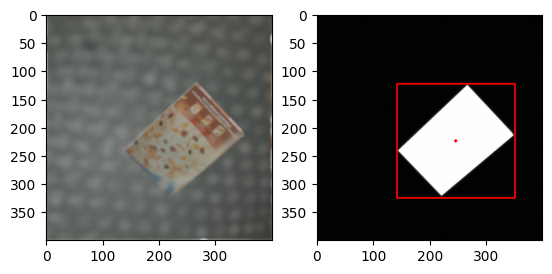

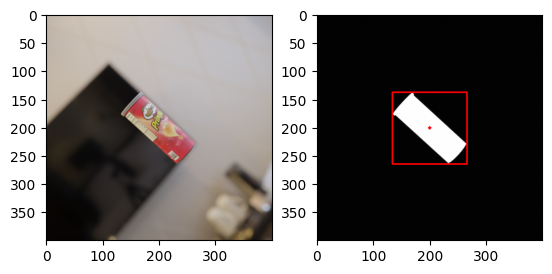

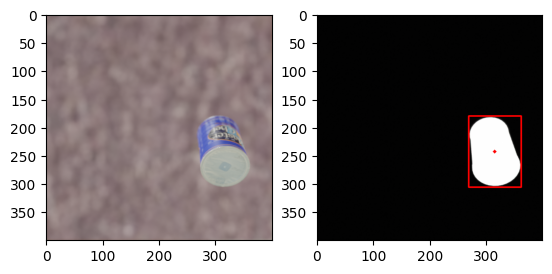

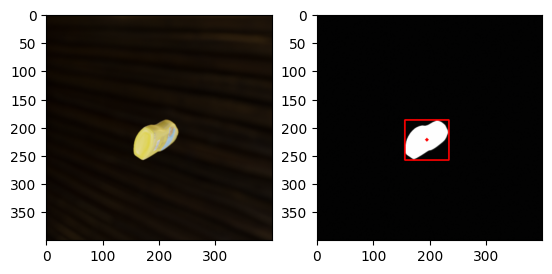

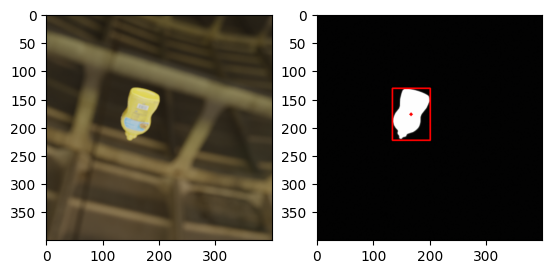

In [14]:
import glob

for object_name in objects_list:
    ob_list = glob.glob(source_images_path + "/" + object_name + "*[!_mask].*")
    ob_list.sort()
    for file_name in ob_list:
        print(file_name.split('/')[-1])
        img = FileUtils.loadImage(file_name)
        mask_path, _, extension = file_name.partition('.')
        mask_path += "_mask." + extension
        mask_img = FileUtils.loadImage(mask_path)
        mask_img = cv2.bitwise_not(mask_img)

        boxes = boxes_from_mask(mask_img)
        # TODO: loop for multiple boxes
        box = boxes[0]
        print("Box:", box)
        result = mask_img.copy()
        cv2.rectangle(result, box[0], box[1], (255, 0, 0), 2)
        #cv2.circle(result, center_coordinates, radius, color, thickness)
        cv2.circle(result, box[2], 1, (255, 0, 0), 3)

        # prop to rect
        # print(yolo_boxes[0])  # box is: ((x_c, y_c) , w, h)
        # prop_img = img.copy()
        # x_shape, y_shape, _ = prop_img.shape

        # w = int(yolo_boxes[0][1] * x_shape)
        # h = int(yolo_boxes[0][2] * y_shape)

        # x_prop = yolo_boxes[0][0][0]
        # y_prop = yolo_boxes[0][0][1]

        # c_x = x_prop * x_shape
        # c_y = y_prop * y_shape

        # x = int(c_x - w/2)
        # y = int(c_y - h/2)

        # print("w, h:", w, h)
        # print("x, y:", x, y)
        # cv2.rectangle(prop_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        

        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(img)
        axarr[1].imshow(result)
        #axarr[2].imshow(prop_img)

    print()

### -----

In [6]:

def boxes_from_mask(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # convert to grayscale
    thresh = cv2.threshold(gray, 8, 255, cv2.THRESH_BINARY)[1]  # threshold
    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    boxes = []
    yolo_boxes = []
    x_shape, y_shape, _ = img.shape
    print("shape:", x_shape, y_shape)
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        #cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 5)
        #print("x,y,w,h:", x, y, w, h)
        c_x = x + w/2
        c_y = y + h/2
        cx_prop = c_x / x_shape
        cy_prop = c_y / y_shape
        w_prop = w / x_shape
        h_prop = h / y_shape
        print("orig w, h:", w, h)
        print("orig x, y:", x, y)
        boxes.append( ((x, y), (x+w, y+h), (int(c_x), int(c_y))) )
        yolo_boxes.append(((cx_prop, cy_prop), w_prop, h_prop))

    return boxes, yolo_boxes

In [ ]:
def label_image(img, box, name=""):
    print()

000_cereal_box_UO-01.png
shape: 400 400
orig w, h: 209 202
orig x, y: 141 123
Box: ((141, 123), (350, 325), (245, 224))
((0.61375, 0.56), 0.5225, 0.505)
w, h: 209 202
x, y: 141 123

001_chips_can-01.png
shape: 400 400
orig w, h: 132 127
orig x, y: 133 138
Box: ((133, 138), (265, 265), (199, 201))
((0.4975, 0.50375), 0.33, 0.3175)
w, h: 132 127
x, y: 133 138

002_master_chef_can-01.png
shape: 400 400
orig w, h: 93 126
orig x, y: 268 180
Box: ((268, 180), (361, 306), (314, 243))
((0.78625, 0.6075), 0.2325, 0.315)
w, h: 93 126
x, y: 268 180

006_mustard_bottle-01.png
shape: 400 400
orig w, h: 78 71
orig x, y: 155 187
Box: ((155, 187), (233, 258), (194, 222))
((0.485, 0.55625), 0.195, 0.1775)
w, h: 78 71
x, y: 155 187
006_mustard_bottle-02.png
shape: 400 400
orig w, h: 67 92
orig x, y: 133 131
Box: ((133, 131), (200, 223), (166, 177))
((0.41625, 0.4425), 0.1675, 0.23)
w, h: 67 92
x, y: 133 131



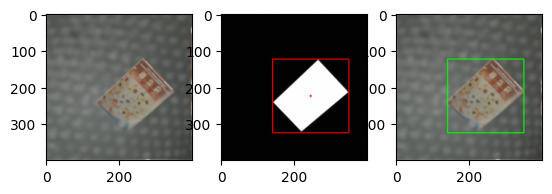

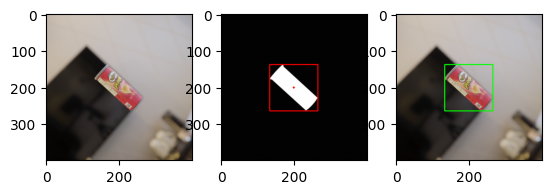

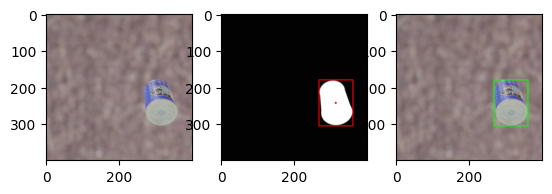

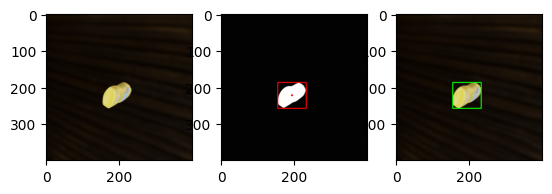

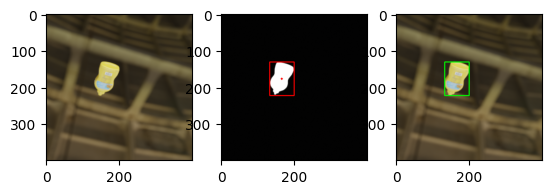

In [49]:
import glob

for object_name in objects_list:
    ob_list = glob.glob(source_images_path + "/" + object_name + "*[!_mask].*")
    ob_list.sort()
    for file_name in ob_list:
        print(file_name.split('/')[-1])
        img = FileUtils.loadImage(file_name)
        mask_path, _, extension = file_name.partition('.')
        mask_path += "_mask." + extension
        mask_img = FileUtils.loadImage(mask_path)
        mask_img = cv2.bitwise_not(mask_img)

        boxes, yolo_boxes = boxes_from_mask(mask_img)
        # TODO: loop for multiple boxes
        box = boxes[0]
        print("Box:", box)
        result = mask_img.copy()
        cv2.rectangle(result, box[0], box[1], (255, 0, 0), 2)
        #cv2.circle(result, center_coordinates, radius, color, thickness)
        cv2.circle(result, box[2], 1, (255, 0, 0), 3)

        # prop to rect
        print(yolo_boxes[0])  # box is: ((x_c, y_c) , w, h)
        prop_img = img.copy()
        x_shape, y_shape, _ = prop_img.shape

        w = int(yolo_boxes[0][1] * x_shape)
        h = int(yolo_boxes[0][2] * y_shape)

        x_prop = yolo_boxes[0][0][0]
        y_prop = yolo_boxes[0][0][1]

        c_x = x_prop * x_shape
        c_y = y_prop * y_shape

        x = int(c_x - w/2)
        y = int(c_y - h/2)

        print("w, h:", w, h)
        print("x, y:", x, y)
        cv2.rectangle(prop_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        

        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(img)
        axarr[1].imshow(result)
        axarr[2].imshow(prop_img)

    print()

### Visualize labels

# -------------------


In [ ]:
img_path = os.path.join(abs_path, "scripts")
print(img_path)
img = FileUtils.loadImage(img_path + "/languages.png")
print(img.shape)
plt.imshow(img)

In [ ]:
resized_img = FileUtils.resizeImage(img, 200)
print(resized_img.shape)
plt.imshow(resized_img)

In [ ]:
FileUtils.saveImage(resized_img, "copy2.png")